In [17]:
#imports 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

In [18]:
#Load the data
print("-------------------------------- Load IS --------------------------------")
experiment_ext = "gk"
name_experiment_is = "is_phi_phi_" + experiment_ext
path_start = "./outputs/" + name_experiment_is + "/"
lst_data_is = []
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_is.append(json.load(file))
                    print("Loaded: " + path)
print("-------------------------------- Load MH --------------------------------")
name_experiment_mh = "/metropolis_phi_phi_gk_first_rules"
path_start = "./outputs/" + name_experiment_mh + "/"
lst_data_mh = []             
for f_day in os.listdir(path_start):
    if os.path.isdir(path_start + f_day):
        for f_hour in os.listdir(path_start + f_day):
            if os.path.isdir(path_start + f_day + "/" + f_hour):
                path = path_start + f_day + "/" + f_hour + "/all.json"
                with open(path, "r") as file:
                    lst_data_mh.append(json.load(file))
                    print("Loaded: " + path)

-------------------------------- Load IS --------------------------------
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-47-02_438/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-58-10_444/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-56-48_442/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-54-50_440/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-56-10_441/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-58-54_445/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-57-35_443/all.json
Loaded: ./outputs/is_phi_phi_gk/2024-08-21/02-54-15_439/all.json
-------------------------------- Load MH --------------------------------
Loaded: ./outputs//metropolis_phi_phi_gk_first_rules/2024-08-23/11-30-10_357/all.json


In [19]:
# For fair comparison it is better to compare with the same true rule
true_rule = lst_data_mh[0]["true_rule"]
for data in lst_data_mh + lst_data_is:
    assert data["true_rule"] == true_rule
    print(len(data["rules"]))

1608
179
185
184
182
185
189
191
188


In [20]:
# Reconstruct all rules IS
all_rules_is = []
all_likelihoods_is = []
all_weights_is = []
for data in lst_data_is:
    all_rules_is.append(np.repeat(data["rules"], data["metrics"]["counts"]))
    all_likelihoods_is.append(np.repeat(data["likelihoods"], data["metrics"]["counts"]))
    all_weights_is.append(np.repeat(data["metrics"]["weights"], data["metrics"]["counts"]))
all_rules_is = np.stack(all_rules_is)
all_likelihoods_is = np.stack(all_likelihoods_is)
all_weights_is = np.stack(all_weights_is)

In [21]:
# Reconstruct all rules MH
all_rules_mh = []
all_likelihoods_mh = []
all_weights_mh = []
all_prev_rules_ind_mh = []
for data in lst_data_mh:
    nb_particles = data["metrics"]["nb_particles"]
    rules = np.array(data["rules"])
    likelihoods = np.array(data["likelihoods"])
    weights =  np.array(data["metrics"]["weights"])
    prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
    all_rules_mh.append(rules.reshape((-1, nb_particles)).transpose())
    all_likelihoods_mh.append(likelihoods.reshape((-1, nb_particles)).transpose())
    all_weights_mh.append(weights.reshape((-1, nb_particles)).transpose())
    all_prev_rules_ind_mh.append(prev_rules_ind.reshape((-1, nb_particles)).transpose())
# Concatenate all seeds
all_rules_mh = np.concatenate(all_rules_mh, axis=0)
all_likelihoods_mh = np.concatenate(all_likelihoods_mh, axis=0)
all_weights_mh = np.concatenate(all_weights_mh, axis=0)
all_prev_rules_ind_mh = np.concatenate(all_prev_rules_ind_mh, axis=0)

In [22]:
# Compare best rule for IS and MH
# Best rules of each method
best_taken = 50
best_rules_ind_mh = np.argsort(-all_likelihoods_mh.flatten())[:best_taken]
best_rules_ind_is = np.argsort(-all_likelihoods_is.flatten())[:best_taken]
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten()[best_rules_ind_mh], all_likelihoods_is.flatten()[best_rules_ind_is]])
all_rules = np.concatenate([all_rules_mh.flatten()[best_rules_ind_mh], all_rules_is.flatten()[best_rules_ind_is]])
indices = np.argsort(-all_likelihoods)
for incr, ind in enumerate(indices):
    if ind < best_taken:
        color_start = "\x1b[31m"
        color_end = "\x1b[0m"
    else:
        color_start = "\033[92m"
        color_end = "\033[0m"
    print(
        f"{color_start}-----rule-----:{incr}: {repr(all_rules[ind])}, likelihood: {all_likelihoods[ind]:2f}{color_end}"
    )

-----rule-----:0: 'The rule for the door is: Holding a green key will open the door.', likelihood: -0.216794
-----rule-----:1: 'The rule for the door is: Holding a green key, regardless of size, will open the door.', likelihood: -0.237091
-----rule-----:2: 'Rule: The door opens when holding a green key, regardless of its size or the other objects present.', likelihood: -0.240660
-----rule-----:3: 'The rule for the door is: "The door opens when a green key, regardless of its size, is used."', likelihood: -0.279766
-----rule-----:4: 'The rule for the door is: "The door opens when a green key, regardless of its size, is used."', likelihood: -0.279766
-----rule-----:5: 'The rule for opening the door is: "To open the door, you must hold a green key."', likelihood: -0.281169
-----rule-----:6: 'The rule for the door is: "Open the door with a green key."', likelihood: -0.285762
-----rule-----:7: 'The rule for the door is that it opens only when you are holding a green key, regardless of its si

In [23]:
# Number of sames rules per particle
lst_nb_redundant_rules_mh = []
for particle in all_rules_mh:
    lst_nb_redundant_rules_mh.append(len(particle) - len(set(particle)))
lst_nb_redundant_rules_is = []
for particle in all_rules_is:
    lst_nb_redundant_rules_is.append(len(particle) - len(set(particle))
)
print("Redundant rules per particle for MH: ", lst_nb_redundant_rules_mh)
print("Redundant rules per particle for IS: ", lst_nb_redundant_rules_is)

Redundant rules per particle for MH:  [69, 85, 63, 52, 91, 97, 82, 132]
Redundant rules per particle for IS:  [21, 15, 16, 18, 15, 11, 9, 12]


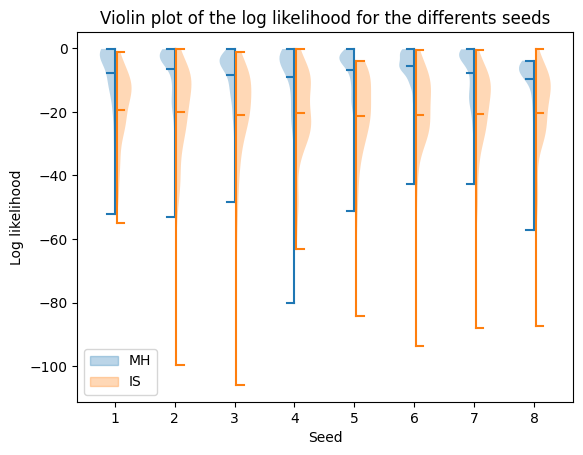

In [24]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
plt.figure()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

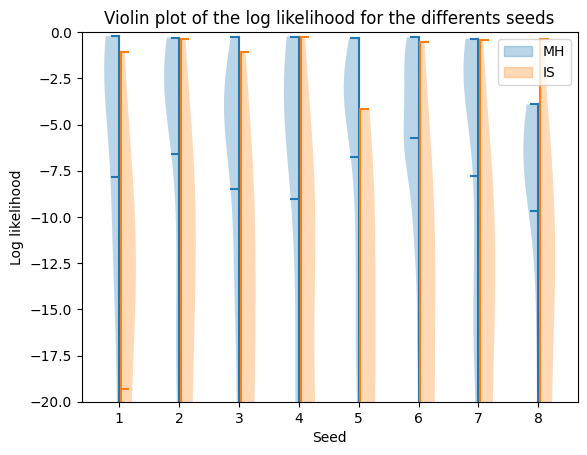

In [25]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
fig,ax = plt.subplots()
color_mh = plt.violinplot(all_likelihoods_mh.transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(all_likelihoods_is.transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods_is))])["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
ax.set_ylim(-20,0)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

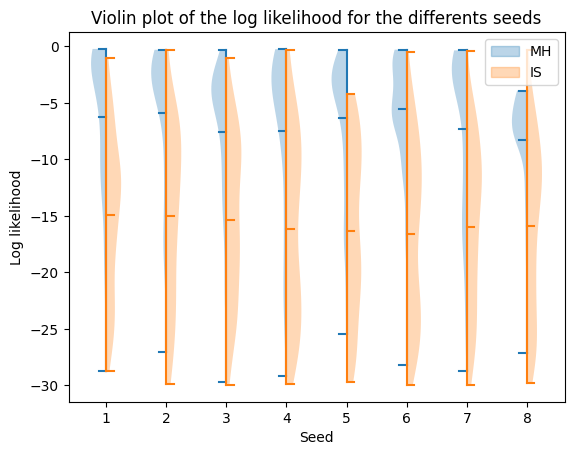

In [26]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms for high likelihoods
min_likelihood=-30
high_likelihoods_mh = [all_likelihoods_mh[row][all_likelihoods_mh[row] > min_likelihood] for row in range(len(all_likelihoods_mh))]
high_likelihoods_is = [all_likelihoods_is[row][all_likelihoods_is[row] > min_likelihood] for row in range(len(all_likelihoods_is))]
fig,ax = plt.subplots()
color_mh = plt.violinplot(high_likelihoods_mh, showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
color_mh = matplotlib.patches.Patch(color=color_mh)
color_is = plt.violinplot(high_likelihoods_is, showmeans=True, side="high")["bodies"][0].get_facecolor().flatten()
color_is = matplotlib.patches.Patch(color=color_is)
plt.legend([color_mh, color_is], ["MH", "IS"])
plt.title("Violin plot of the log likelihood for the differents seeds")
plt.xlabel("Seed")
plt.ylabel("Log likelihood")
plt.show()

# Embeddings

In [27]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules_mh.flatten(), all_rules_is.flatten()], axis=0))

### t-SNE

In [28]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

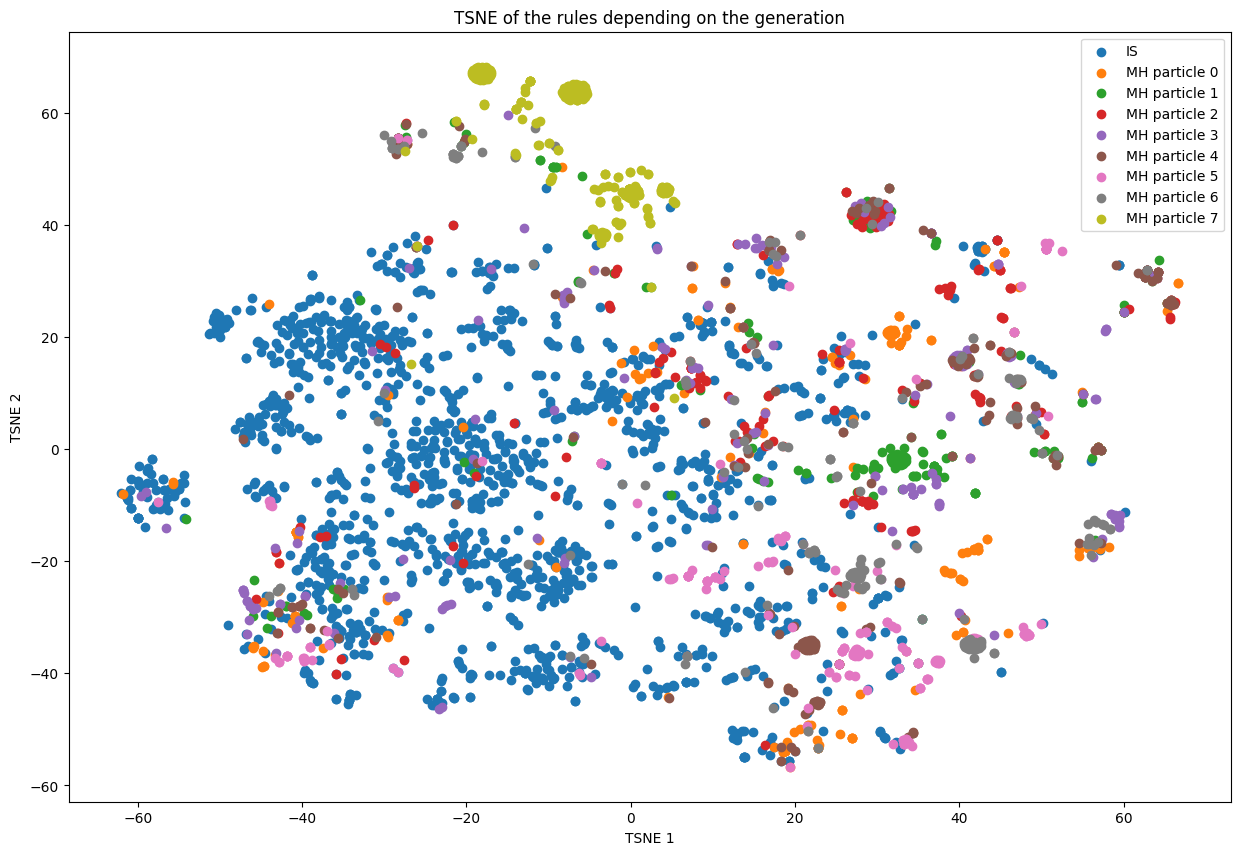

In [29]:
# Plot the embeddings
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[len(all_rules_mh.flatten()):,0], proj_embeddings[len(all_rules_mh.flatten()):,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    plt.scatter(proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],0], proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

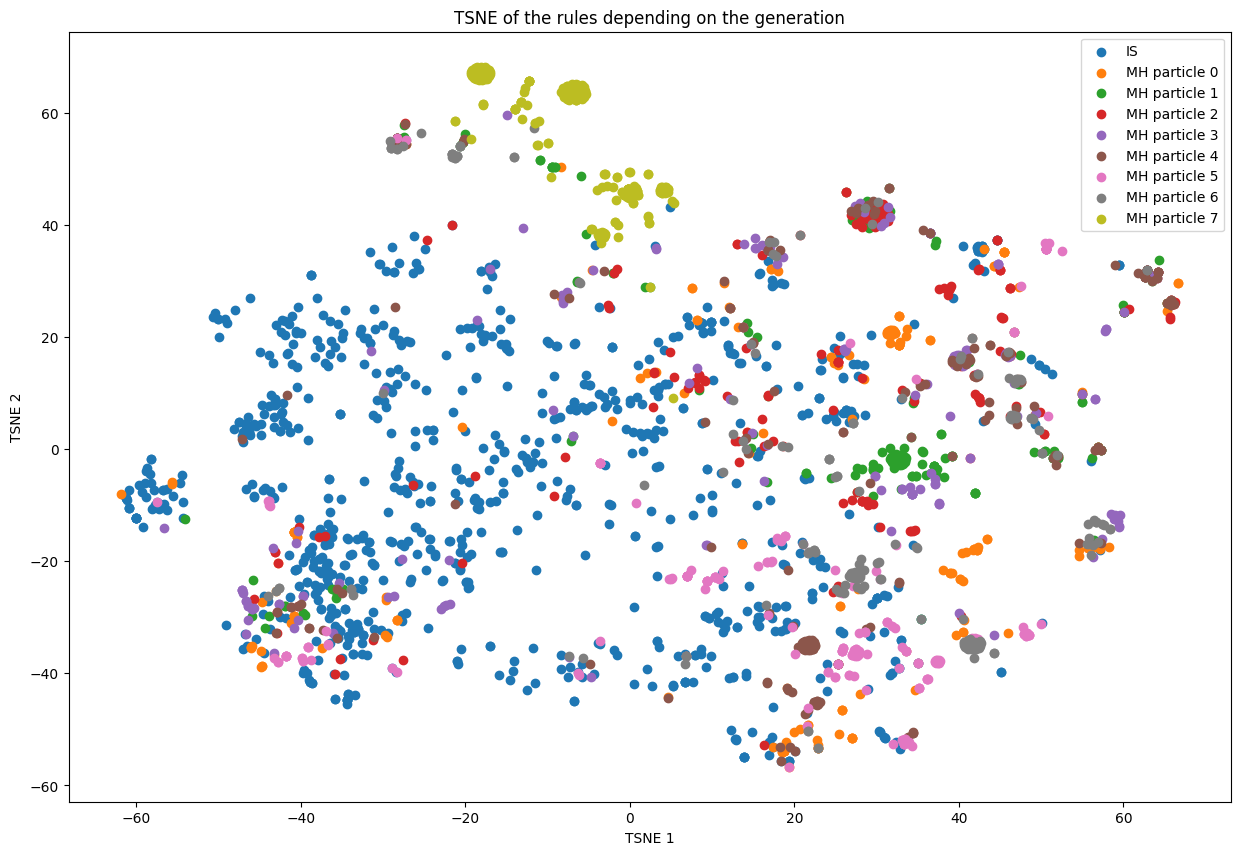

In [30]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -20
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_mh.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    mask_mh = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_mh.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_mh.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_mh,0], proj_embeddings[mask_likelihood&mask_mh,1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [35]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

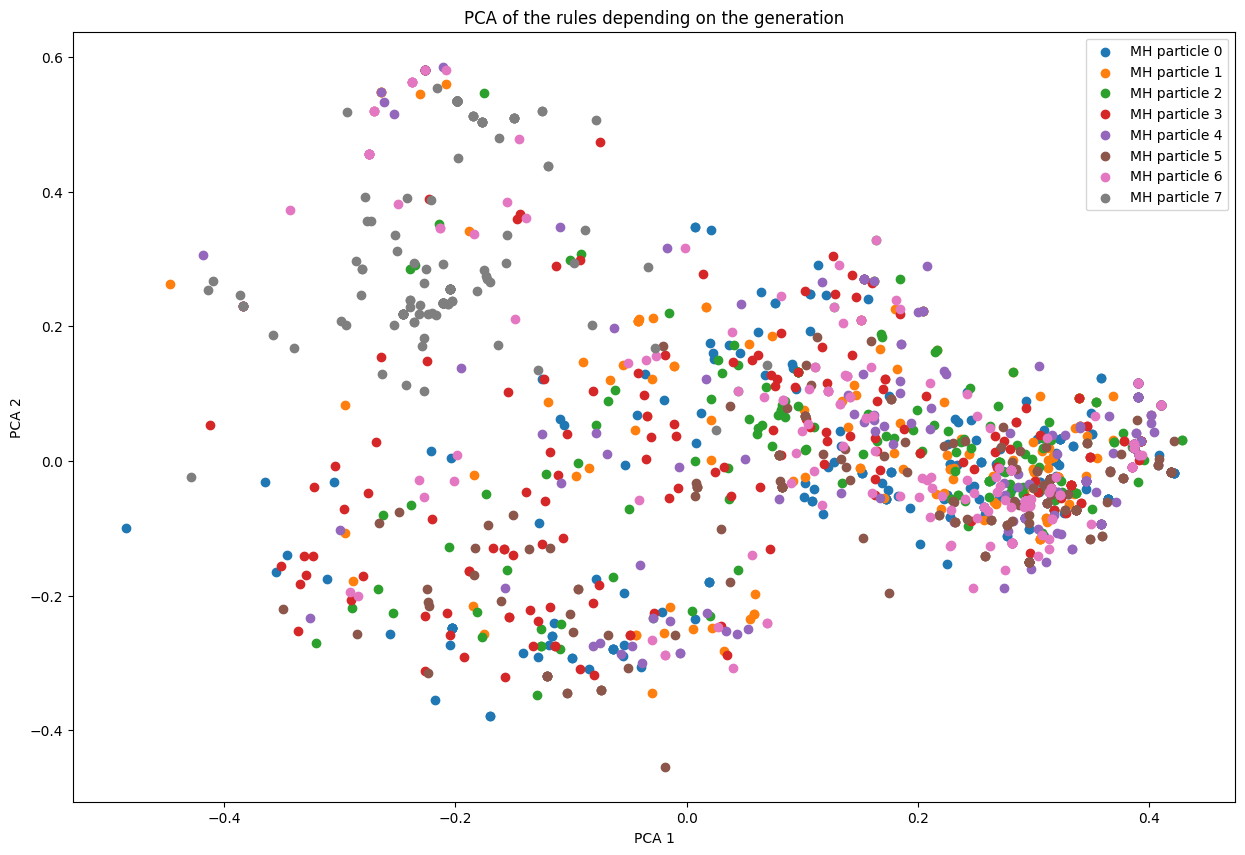

In [38]:
# Plot the embeddings
plt.figure(figsize=(15,10))
#plt.scatter(proj_embeddings[len(all_rules_mh.flatten()):,0], proj_embeddings[len(all_rules_mh.flatten()):,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    plt.scatter(proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],0], proj_embeddings[i*all_rules_mh.shape[1]: (i+1)*all_rules_mh.shape[1],1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

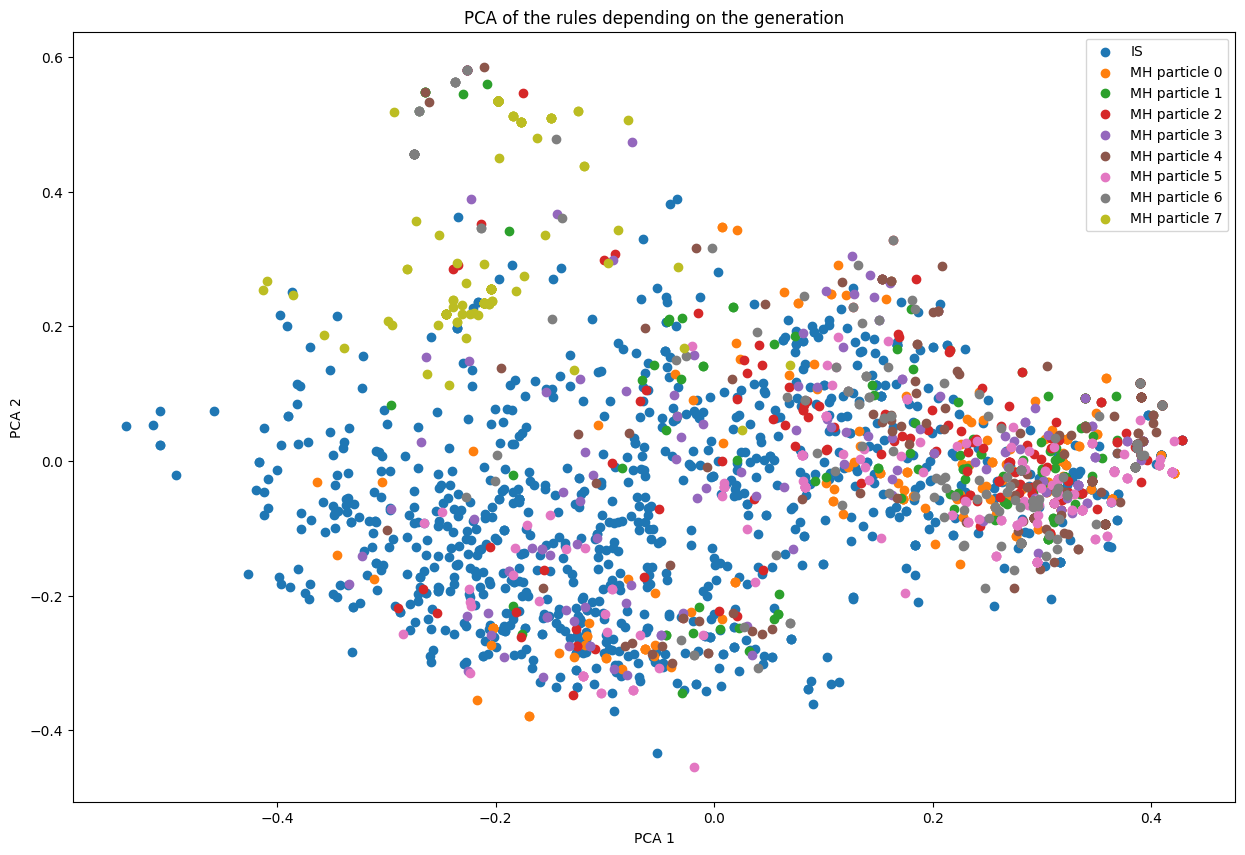

In [33]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
all_likelihoods = np.concatenate([all_likelihoods_mh.flatten(), all_likelihoods_is.flatten()])
mask_likelihood = all_likelihoods > -20
mask_is = np.arange(len(all_likelihoods)) >= len(all_rules_mh.flatten())
plt.figure(figsize=(15,10))
plt.scatter(proj_embeddings[mask_likelihood&mask_is,0], proj_embeddings[mask_likelihood&mask_is,1], label="IS")
#Plot MH particles
for i in range(len(all_rules_mh)):
    mask_mh = (np.arange(len(all_likelihoods)) < (i+1)*all_rules_mh.shape[1]) & (np.arange(len(all_likelihoods)) >= i*all_rules_mh.shape[1])
    plt.scatter(proj_embeddings[mask_likelihood&mask_mh,0], proj_embeddings[mask_likelihood&mask_mh,1], label="MH particle "+str(i))
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()